In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.figure(figsize=(10,6))
    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)
        
    #plt.plot(time[start:end], series[start:end], format)
    plt.xlabel('time')
    plt.ylabel('value')
    if label:
        plt.legend(fontsize=14, labels=label)
    plt.grid(True)
    plt.show()

In [3]:
#straight line trend
def trend(time, slope=0):
    series = time * slope
    return series

In [4]:
def seasonal_pattern(season_time):
    data_pattern = np.where(season_time < 0.4, 
                           np.cos(season_time*2*np.pi),
                           1/np.exp(3*season_time))
    return data_pattern

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase)%period)/period
    data_pattern = amplitude * seasonal_pattern(season_time)
    return data_pattern

In [5]:
# Generate time steps
time = np.arange(4 * 365 + 1)

# Define the parameters of the seasonal data
period = 365
amplitude = 40

series = seasonality(time, period=period, amplitude=amplitude)

In [6]:
# Define seasonal parameters
slope = 0.05
period = 365
amplitude = 40

# Generate the data
series = trend(time, slope) + seasonality(time, period=period, amplitude=amplitude)

In [7]:
def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    noise = rnd.randn(len(time)) * noise_level
    return noise

In [8]:
noise_level = 5
noise_signal = noise(time, noise_level=noise_level, seed=42)

In [9]:
series = series + noise_signal

In [10]:
import tensorflow as tf

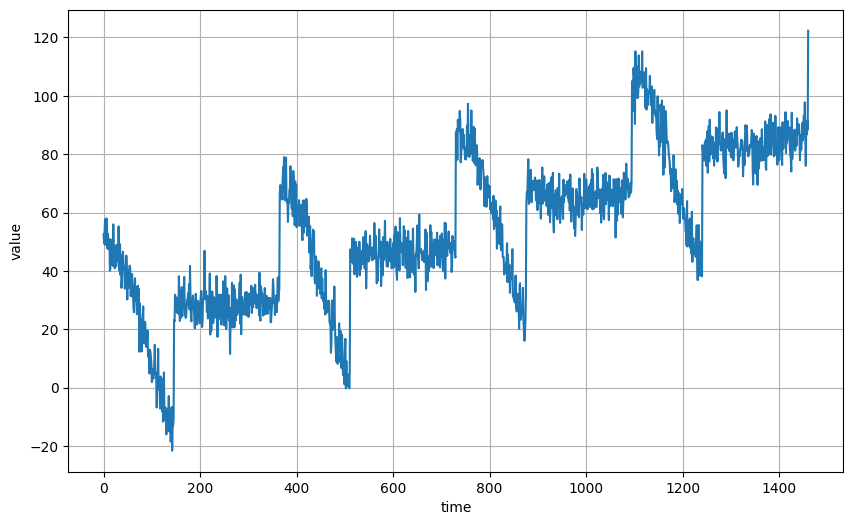

In [11]:
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series)

In [12]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_test = time[split_time:]
x_test = series[split_time:]

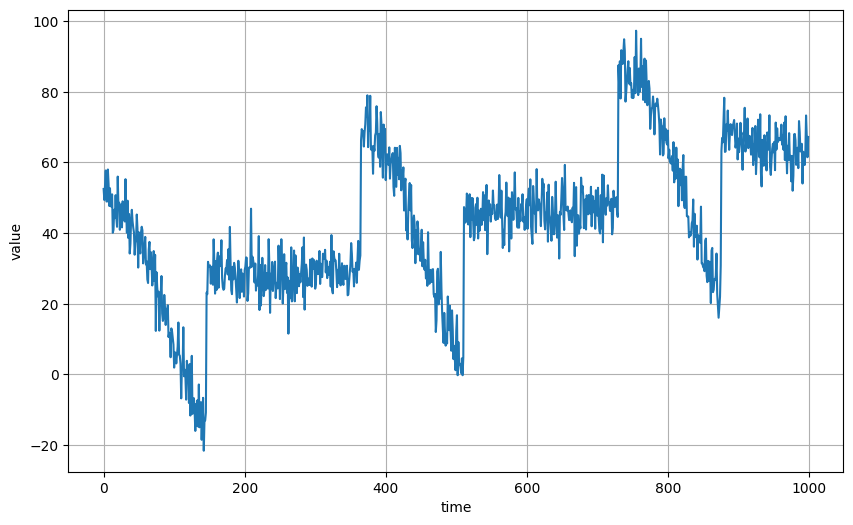

In [13]:
plot_series(time_train, x_train)

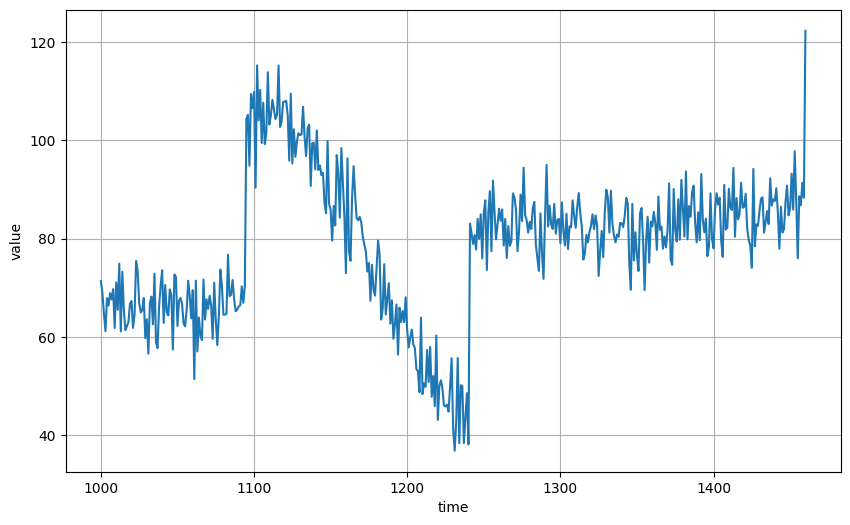

In [14]:
plot_series(time_test, x_test)

In [15]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [16]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(size=window_size+1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset        

In [17]:
dataset = windowed_dataset(series, window_size, batch_size, shuffle_buffer_size)

In [18]:
for windows in dataset.take(1):
  print(f'data type: {type(windows)}')
  print(f'number of elements in the tuple: {len(windows)}')
  print(f'shape of first element: {windows[0].shape}')
  print(f'shape of second element: {windows[1].shape}')

data type: <class 'tuple'>
number of elements in the tuple: 2
shape of first element: (32, 20)
shape of second element: (32,)


In [19]:
import tensorflow.keras as keras
l0 = keras.layers.Dense(1, input_shape=[window_size])
model = keras.models.Sequential([l0])
model.compile(optimizer="sgd", loss='mse')

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 21 (84.00 Byte)
Trainable params: 21 (84.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))
#model.compile(loss='mse', optimizer='sgd')

In [22]:
history = model.fit(dataset, epochs=100, verbose=0)

In [23]:
# Shape of the first 20 data points slice
print(f'shape of series[0:20]: {series[0:20].shape}')

# Shape after adding a batch dimension
print(f'shape of series[0:20][np.newaxis]: {series[0:20][np.newaxis].shape}')

# Shape after adding a batch dimension (alternate way)
print(f'shape of series[0:20][np.newaxis]: {np.expand_dims(series[0:20], axis=0).shape}')

# Sample model prediction
print(f'model prediction: {model.predict(series[0:20][np.newaxis])}')

shape of series[0:20]: (20,)
shape of series[0:20][np.newaxis]: (1, 20)
shape of series[0:20][np.newaxis]: (1, 20)
1/1 [==============================] - 0s 73ms/step
model prediction: [[46.857296]]


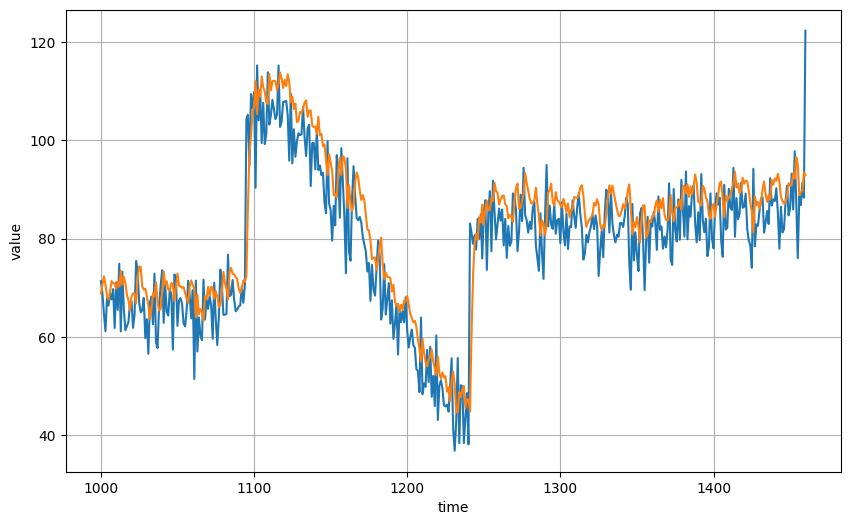

In [24]:
forecast = []

for time in range(split_time-window_size, len(series)-window_size):
    forecast.append(model.predict(series[time: time+window_size][np.newaxis], verbose=5))
    
len(time_test), len(x_test), len(forecast)
plot_series(time_test, (x_test, np.array(forecast).squeeze()))

In [25]:
print(tf.keras.metrics.mean_squared_error(x_test, np.array(forecast).squeeze()).numpy())
print(tf.keras.metrics.mean_absolute_error(x_test, np.array(forecast).squeeze()).numpy())

58.163406
6.0586267


In [26]:
model_deep = keras.models.Sequential([
    keras.layers.Dense(10, input_shape=[window_size], activation='relu'),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(1)
])
model_deep.summary()
model_deep.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 331 (1.29 KB)
Trainable params: 331 (1.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [27]:
model_deep.fit(dataset, epochs=100, verbose=0)

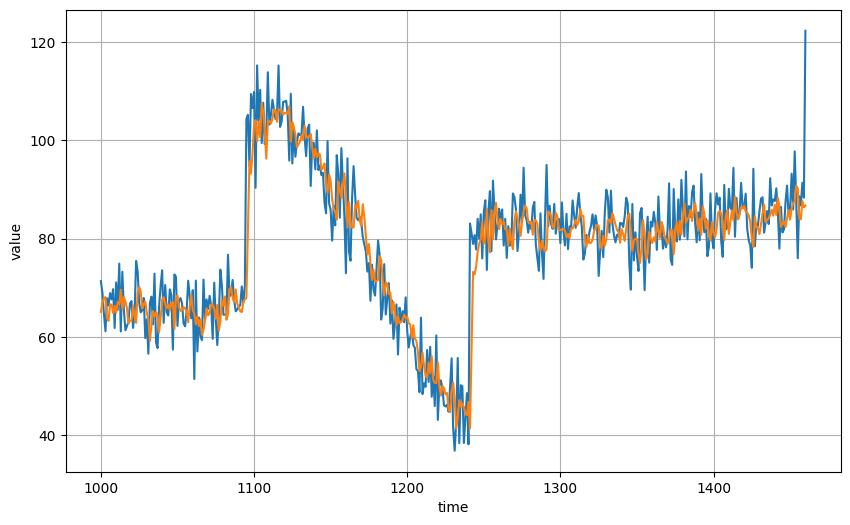

In [28]:
forecast = []

for time in range(split_time-window_size, len(series)-window_size):
    forecast.append(model_deep.predict(series[time: time+window_size][np.newaxis], verbose=5))
    
len(time_test), len(x_test), len(forecast)
plot_series(time_test, (x_test, np.array(forecast).squeeze()))

In [29]:
print(tf.keras.metrics.mean_squared_error(x_test, np.array(forecast).squeeze()).numpy())
print(tf.keras.metrics.mean_absolute_error(x_test, np.array(forecast).squeeze()).numpy())

44.881947
4.9253206
